In [4]:
! export JUPYTER_PATH=.:$JUPYTER_PATH

In [5]:
! export PYTHONPATH=.:$PYTHONPATH

In [1]:
import torch
import numpy as np
from sklearn.manifold import TSNE


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
get_ipython().magic(u'matplotlib inline')


In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

# concept embedding 

First, we will try to analyze what to do with the concept embeddings - what has been learned? how does it differe with the original?

1. compare the semantic space of the original concept glove vs learned concept 

In [5]:
concept_path_n = '/mount/studenten/arbeitsdaten-studenten1/advanced_ml/sgg_vqa_je/AML-group-3/lcgn/exp_gqa/pytorch_ckpt_27/lcgn_objects/0010.ckpt'
state_dict = torch.load(concept_path_n, map_location = 'cpu')
concept_embedding = state_dict['model']['lcgn.embeddingsConceptVar']
learned_concept_embeddings = concept_embedding.numpy()


In [6]:
initial_concept_embeddings = np.load('/mount/studenten/arbeitsdaten-studenten1/advanced_ml/sgg_vqa_je/AML-group-3/lcgn/exp_gqa/data/concept_300d.npy')

In [7]:
initial_concept_embeddings.shape

(78, 300)

In [8]:
learned_concept_embeddings.shape

(79, 300)

In [9]:
combined  = np.vstack((learned_concept_embeddings,initial_concept_embeddings))

In [10]:
combined.shape


(157, 300)

In [11]:
def plot_cpt_emb_change(cmb, p=4):
    tsne = TSNE(perplexity=p)
    tse_cmb = tsne.fit_transform(cmb)
    N = (len(combined)-1)//2
    clb = list(range(1, N+1)) + [N] + list(range(1, N))

    def get_cmap(n, name='hsv'):
        '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
        RGB color; the keyword argument name must be a standard mpl colormap name.'''
        return plt.cm.get_cmap(name, n)

    cmap = [np.random.rand(3,) for _ in range(N)]

    for i in range(N):
        x = [tse_cmb[i,0],tse_cmb[i+N+1,0]]
        y = [tse_cmb[i,1],tse_cmb[i+N+1,1]]
        plt.plot(x, y, label=clb[i], linewidth=0.1, color=cmap[i])

    plt.scatter(tse_cmb[78,0], tse_cmb[78,1], marker='*', label='nCPT')
    for i in range(78):
        plt.scatter(tse_cmb[i+N+1,0], tse_cmb[i+N+1,1], marker='o', label=clb[i],color=cmap[i])
        plt.scatter(tse_cmb[i, 0], tse_cmb[i, 1],
                    marker='s', label=clb[i], color=cmap[i])
    plt.show()


In [4]:
import random

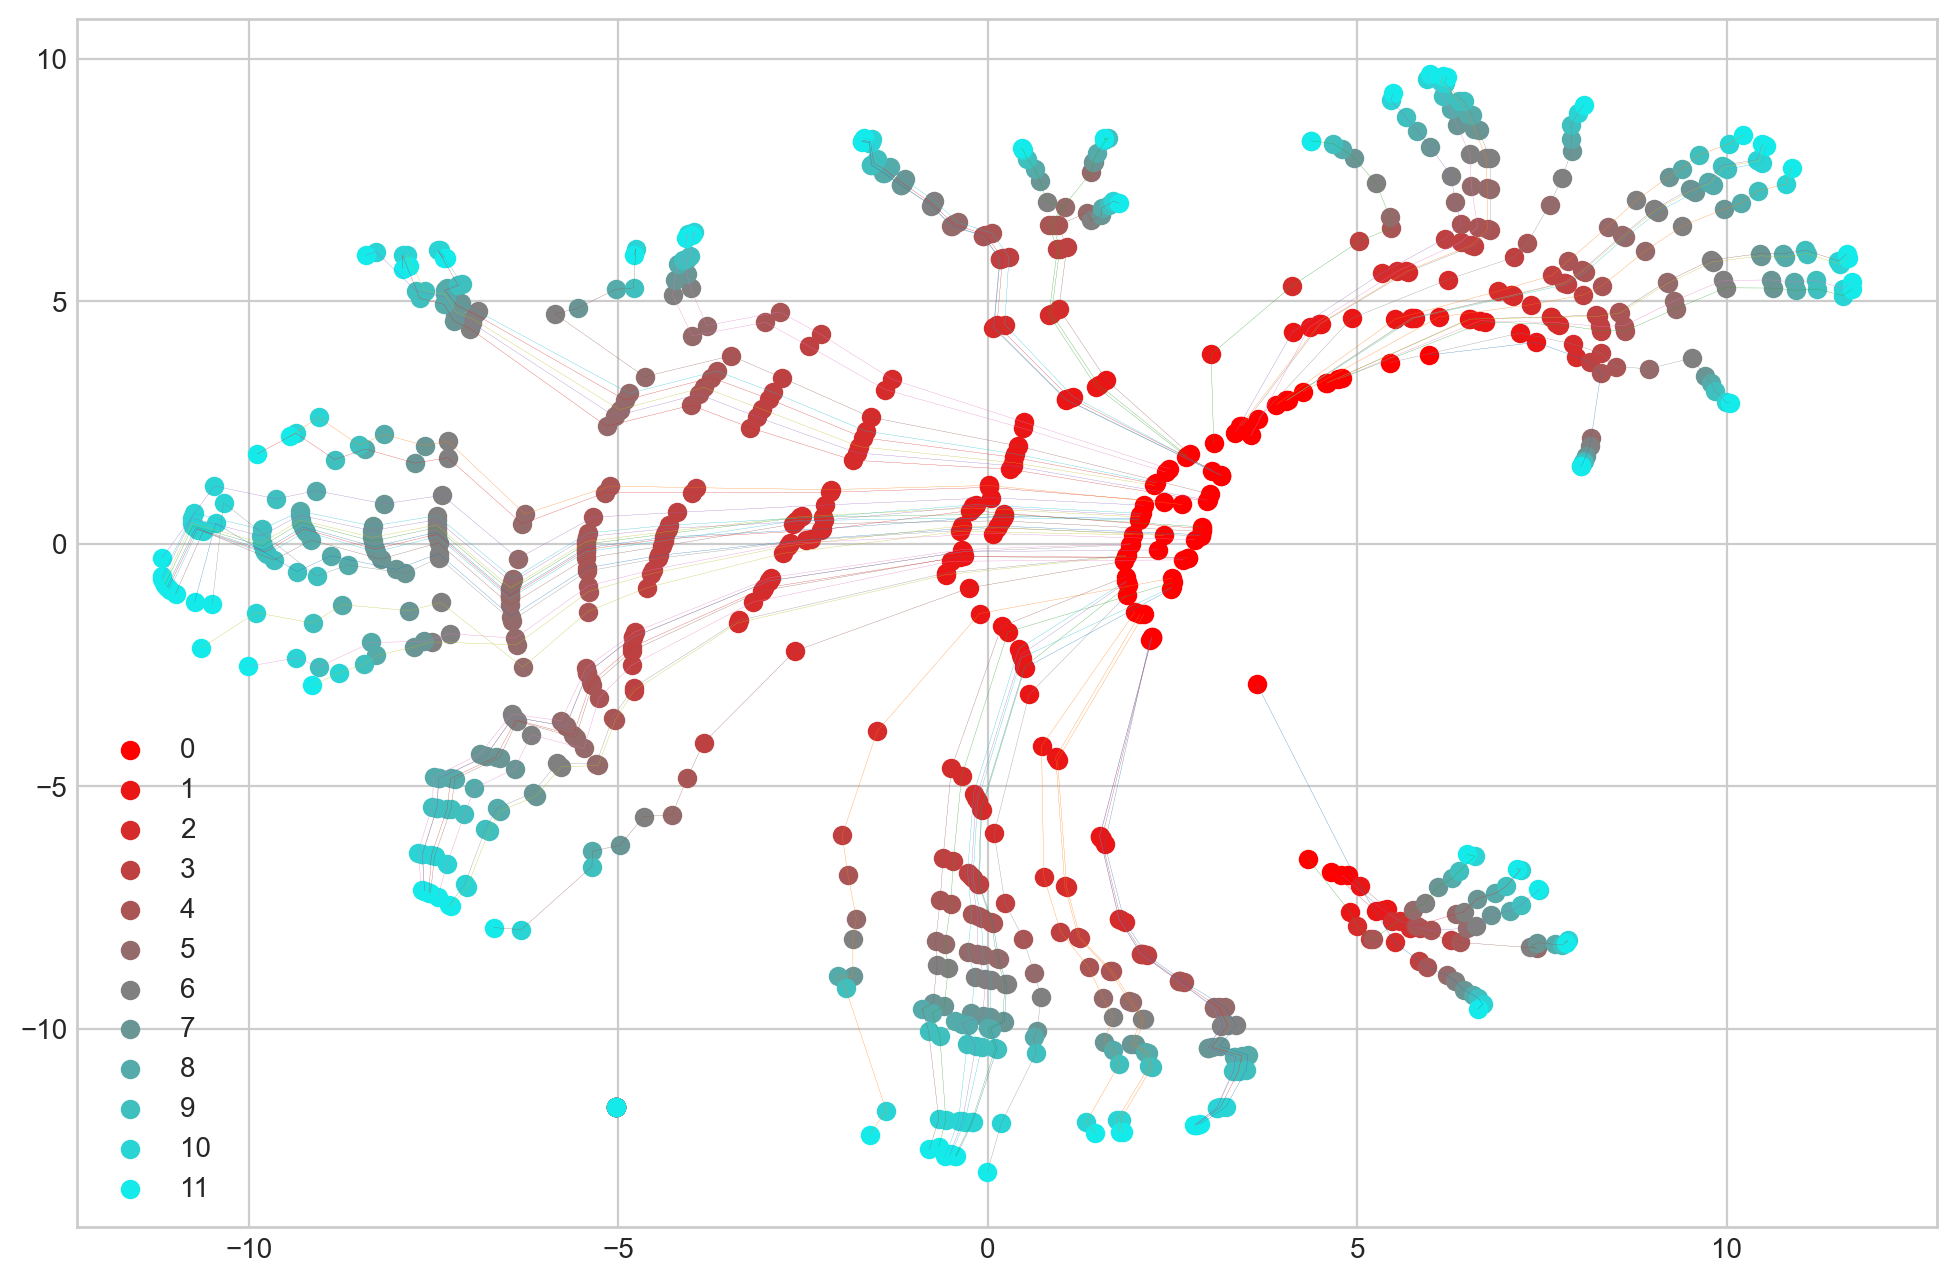

In [6]:
def plot_cpt_over_epochs(p=10):

    paths = ['/mount/studenten/arbeitsdaten-studenten1/advanced_ml/sgg_vqa_je/AML-group-3/lcgn/exp_gqa/pytorch_ckpt_27/lcgn_objects/%04d.ckpt' % i 
                for i in range(1,13)]

    cmap = [(1-i*(1/len(paths)), i*(1/len(paths)), i*(1/len(paths)))
            for i in range(len(paths))]
    clb = list(range(len(paths)))
    embs = []
    for path in paths:
        state_dict = torch.load(path, map_location = 'cpu')
        concept_embedding = state_dict['model']['lcgn.embeddingsConceptVar']
        lce = concept_embedding.numpy()
        embs.append(lce)
    
    tsne = TSNE(perplexity=p)
    embs = np.stack(embs)

    B, C, H = embs.shape
    embs = embs.reshape(-1,H)
    tse_cmb = tsne.fit_transform(embs)

    tse_cmb = tse_cmb.reshape(B, C, -1)

    for k in range(C):
        x = tse_cmb[:,k,0]
        y = tse_cmb[:,k,1]
        plt.plot(x, y, linewidth=0.1)
        
    for i in range(B):
        for j in range(C):
            plt.scatter(tse_cmb[i,j,0], tse_cmb[i,j,1], marker='o', label= i, color=cmap[i])
    
    plt.legend()
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
    
    return 


plot_cpt_over_epochs(p=150)



    


maybe the problem is not that the concept embeddings are not being learned properly because regardless of the concepts being properly learned or not - the accuracy does not change?!!!

the concept embeddings of the models that we have seen when we have linear operations did not allow for proper manifolds of the concept embedding to form - however we see that this does not actually affect the performance at all! 

this seems to suggest two things 

1. the concept embedding that is being learned is wrong - because it is being learned concurrently with the graph itself 
2. the non-sparsity in the softmax is exacerbating this 


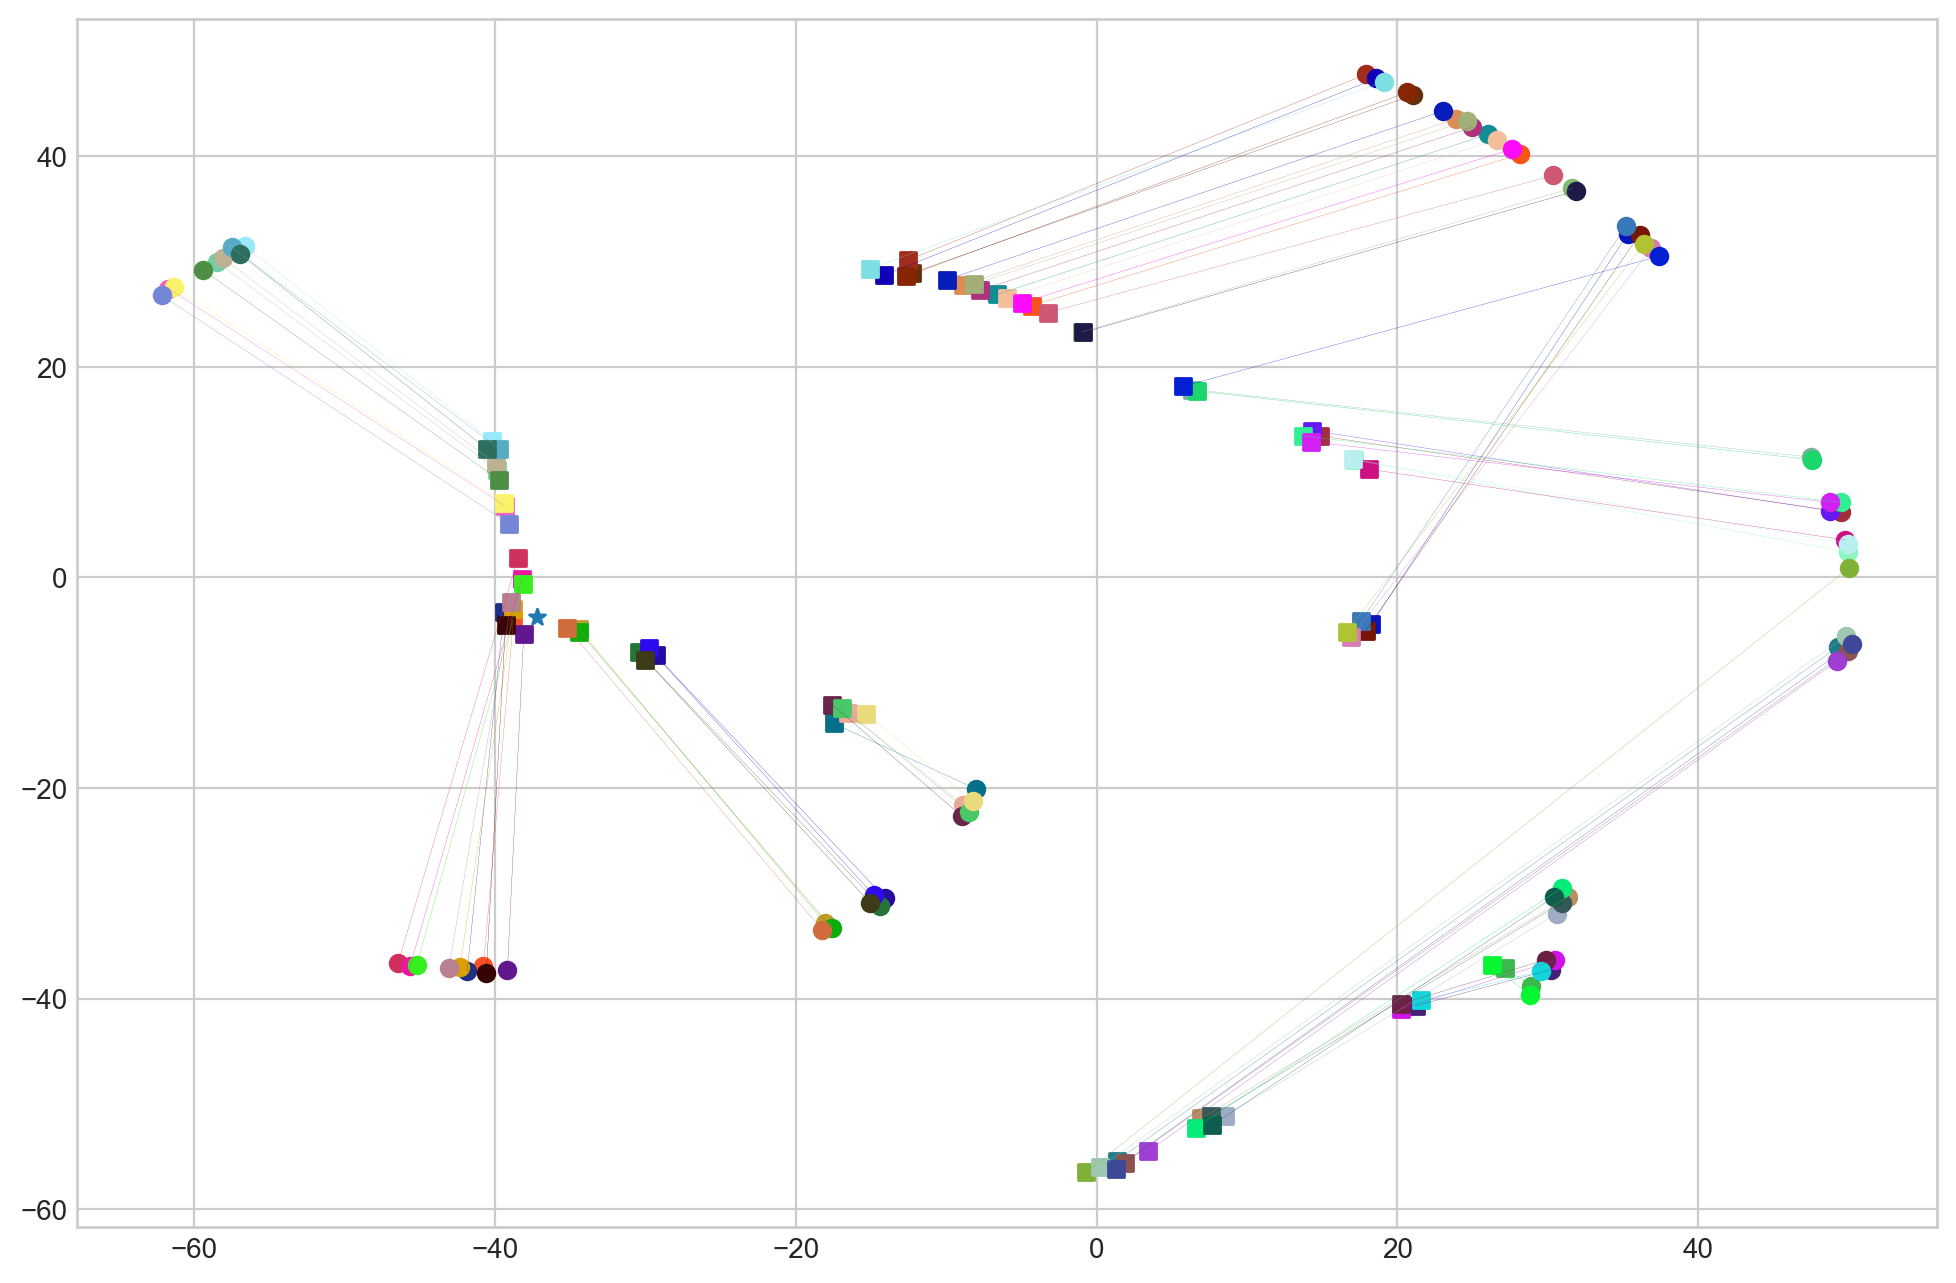

In [17]:
plot_cpt_emb_change(combined)


Seems like initializing the concept embeddings becomes a very strong prior - the change of concept embedding from before and after training did not change the feature space much 

# learned from scratch - how does it look like?

In [54]:
concept_path_f = '/mount/studenten/arbeitsdaten-studenten1/advanced_ml/sgg_vqa_je/AML-group-3/lcgn/exp_gqa/pytorch_ckpt_13/lcgn_objects/0011.ckpt'
concept_path_f_1 = '/mount/studenten/arbeitsdaten-studenten1/advanced_ml/sgg_vqa_je/AML-group-3/lcgn/exp_gqa/pytorch_ckpt_13/lcgn_objects/0001.ckpt'
def load_concept_emb(path):
    sd= torch.load(path, map_location='cpu')
    ce = sd['model']['lcgn.embeddingsConceptVar']
    lce = ce.numpy()

    return lce



In [55]:
lce_f_1 = load_concept_emb(concept_path_f_1)
lce_f_13 = load_concept_emb(concept_path_f)


In [58]:
lce_combined = np.vstack([lce_f_1, lce_f_13[:-1]])

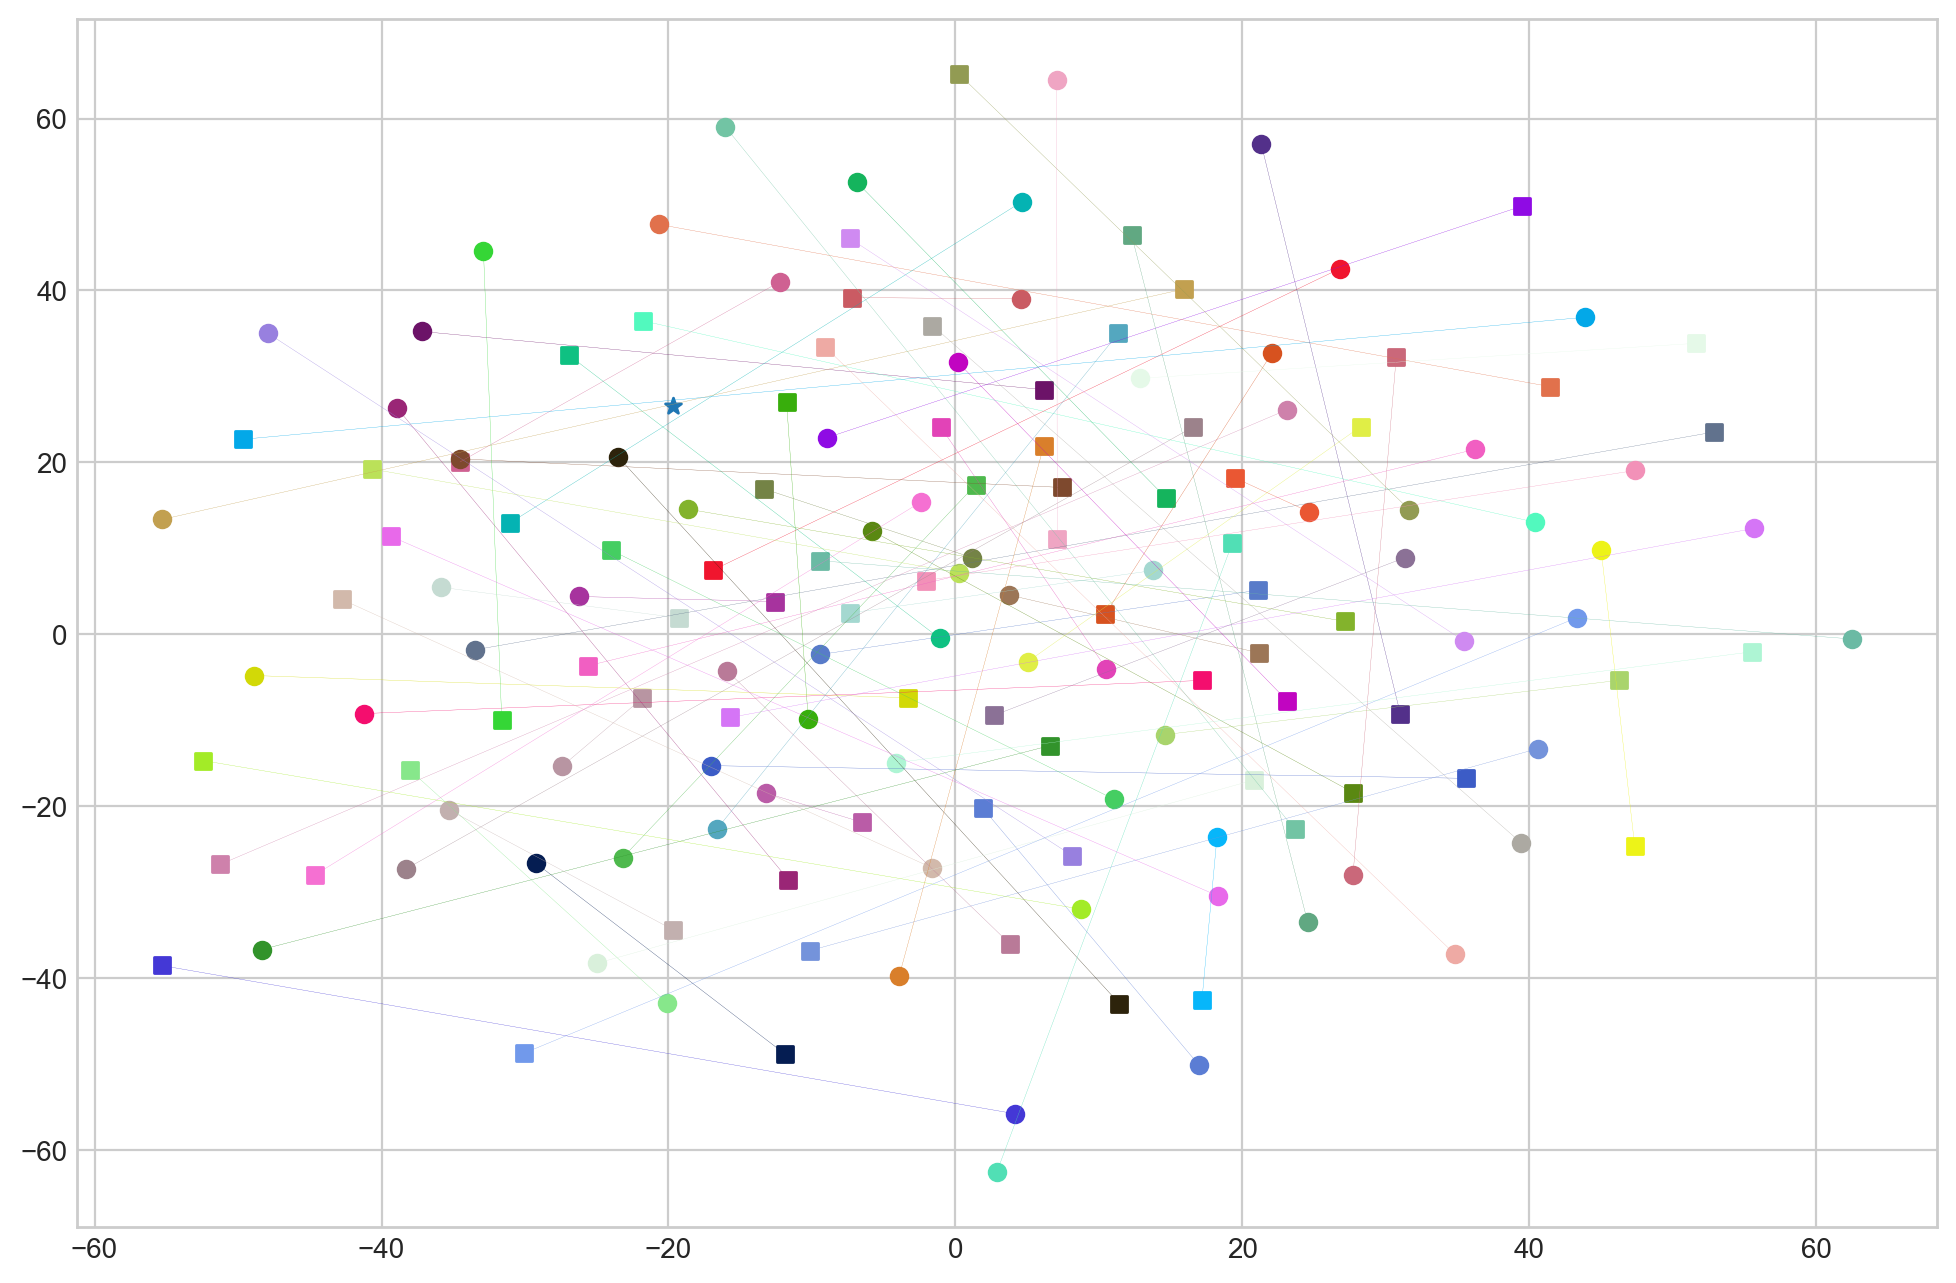

In [69]:
plot_cpt_emb_change(lce_combined, 4)


In [38]:
def plot_random_init_cpt(cpt, perp=3):
    
    tsne = TSNE(perplexity=perp)
    cpt = tsne.fit_transform(cpt)
    cpt_labels = list(range(1, len(cpt)+1))
    for i in range(len(cpt)):
        plt.scatter(cpt[i,0], cpt[i,1], marker='o', label=cpt_labels[i])

    plt.show()


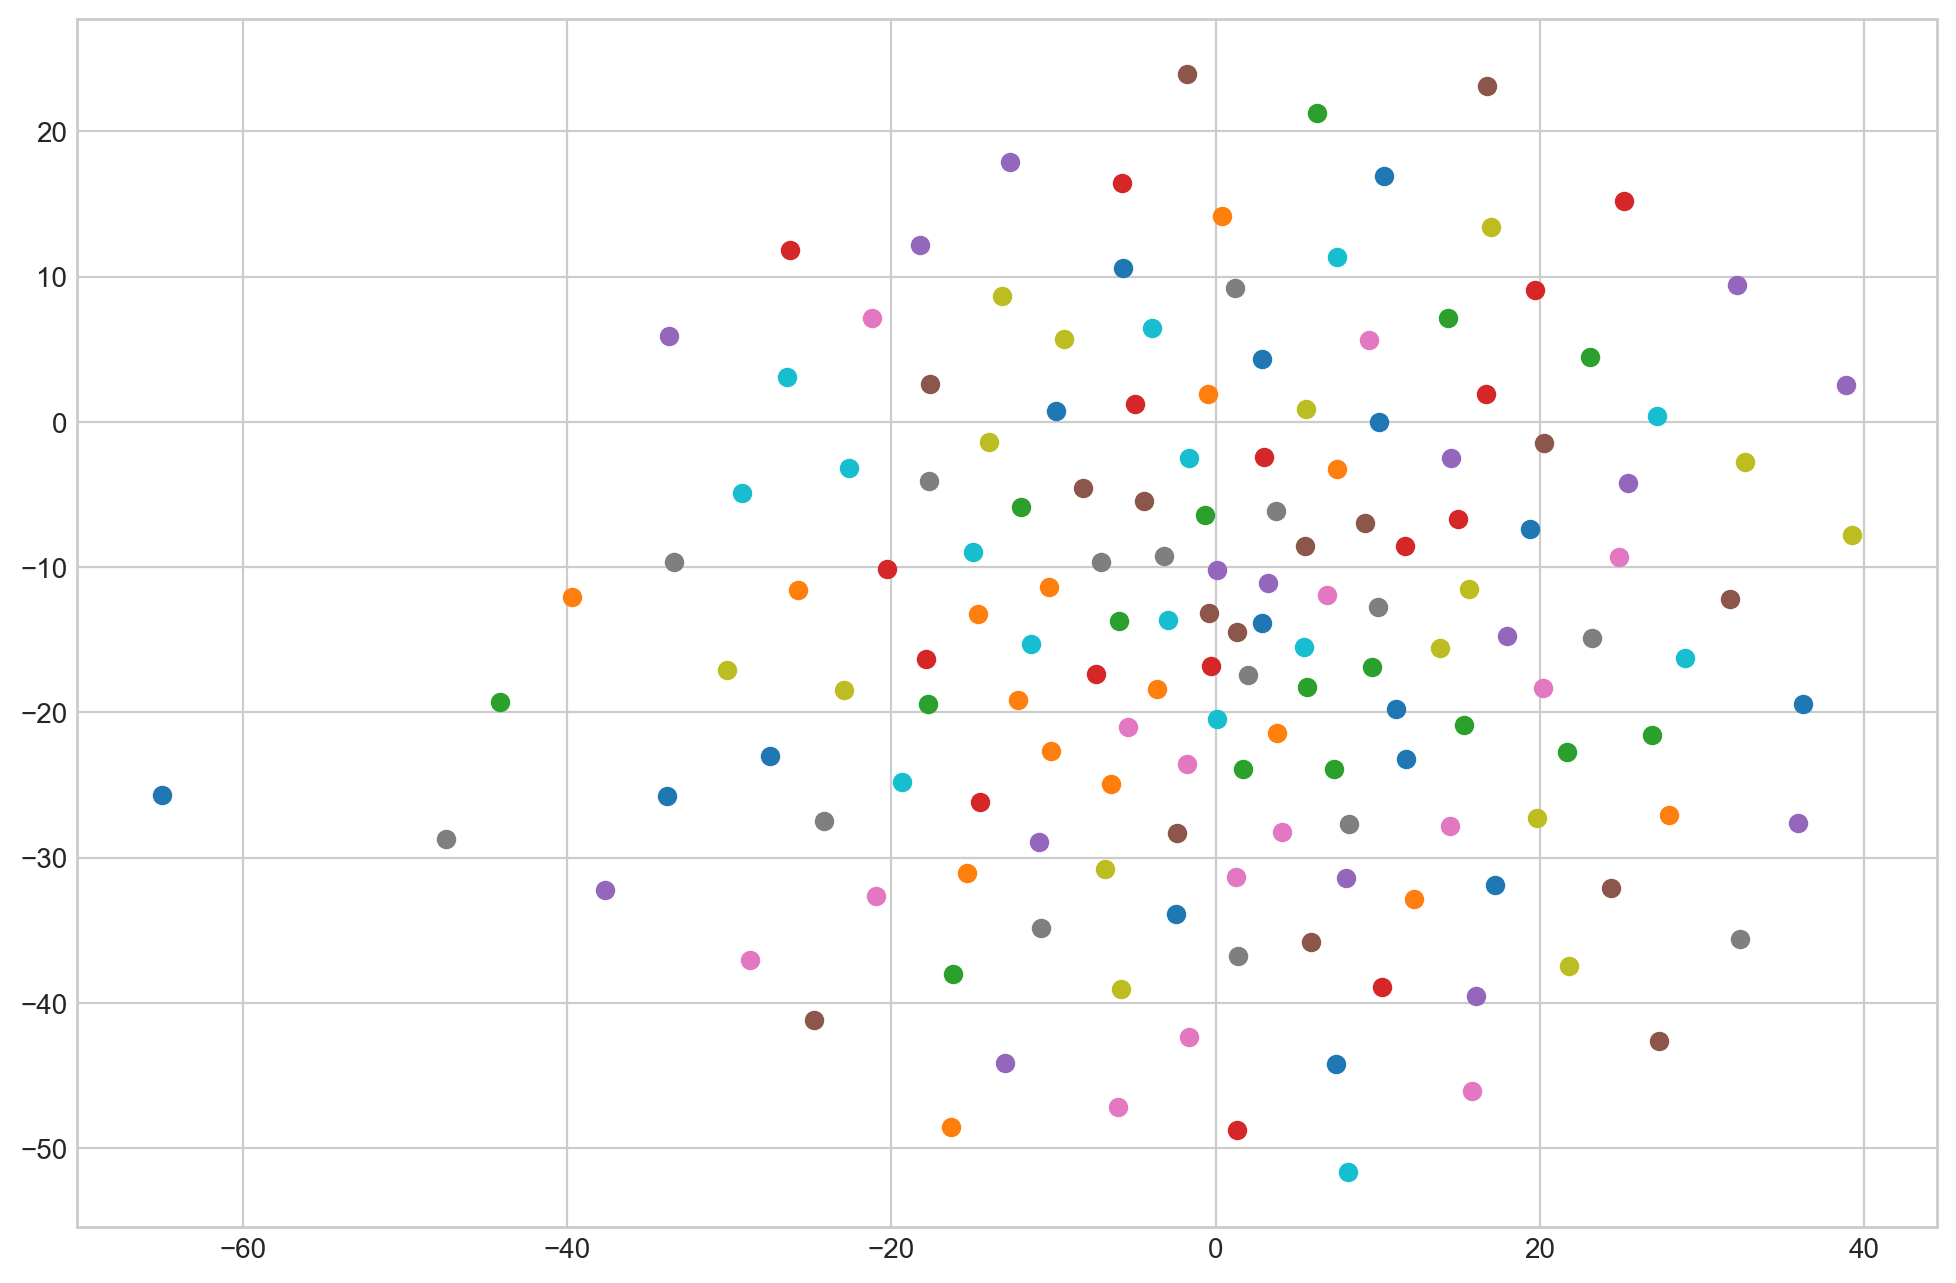

In [48]:
plot_random_init_cpt(lce_f, 4)

it seems that essentially what the model was doing was workign with these concept embeddings without changing them..??????

hence we need to test ways to fix this 

1. is this due to the lack of non-linearity in the reasoning process?
    a. we can apply non-linearity after each concept 
    b. we can apply non-linearity in allowing to change the value to the concepts 
2. or is this due to the variable receiving no gradient information for some reason